Chris Richardson <br><br>

October 17, 2022 <br><br>

ADS-509-Fall <br><br>

Github Link: [https://github.com/CFRichardson/ADS_509_HW6](https://github.com/CFRichardson/ADS_509_HW6)

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [2]:
from nltk.tokenize import word_tokenize
def dict_2_df_lexicon_builder(dict_):

    df = pd.DataFrame.from_dict(dict_, orient='index').reset_index()
    df.rename(columns={'index':'words',
                       0:'values'},
              inplace=True)
    print('Shape', df.shape)
    return df

In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Volumes/GoogleDrive/My Drive/_509/my_M1_data"

# These subfolders should still work if you correctly stored the
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data
path_ = data_location + '/lyrics/FFDP/FFDP_song_lyrics_df.csv'
ffdp_lyrics = pd.read_csv(path_)

# Read in the lyrics data
path_ = data_location + '/lyrics/OfficialRezz/OfficialRezz_song_lyrics_df.csv'
rezz_lyrics = pd.read_csv(path_)

In [5]:
# Read in the twitter data
path_ = data_location + '/twitter/FFDP_followers_data.txt'
ffdp_twitter = pd.read_csv(path_,
                           sep="\t",
                           engine='python')

path_ = data_location + '/twitter/OfficialRezz_followers_data.txt'
rezz_twitter = pd.read_csv(path_,
                           sep="\t",
                           engine='python')

## Bing Liu Lexicon build


In [6]:
bing_liu_df = {}
word_files = [negative_words_file, positive_words_file]

for file_num, file_ in enumerate(word_files):
    with open(file_, 'r', encoding="ISO-8859-1") as f:

        for idx, line in enumerate(f.readlines()):

            if line[:1] != ';' and line != '\n':

                if file_num == 0: # negative_words_file
                    bing_liu_df[line[:-1]] = -1
                else:
                    bing_liu_df[line[:-1]] = +1

bing_liu_df = dict_2_df_lexicon_builder(bing_liu_df)
bing_liu_df.sample(5)

Shape (6786, 2)


,words,values
3812,shrug,-1
3079,obstinate,-1
564,checkered,-1
3459,rascal,-1
932,demeaning,-1


## TidyText Lexicon

In [7]:
tidytext_df = pd.read_csv(tidy_text_file, sep='\t')
print('Shape', tidytext_df.shape)
tidytext_df.sample(10)

Shape (15133, 3)


,word,sentiment,lexicon
6436,caustically,negative,bing
8993,inexorably,negative,bing
8115,forebodingly,negative,bing
11690,thriving,positive,bing
9077,insecure,negative,bing
11126,slothful,negative,bing
13177,displace,negative,loughran
5663,abundant,positive,bing
786,charade,negative,nrc
5634,zest,positive,nrc


## The Great Lexicon Merge
Interestingly TidyText already has Bing Liu lexicon, but I assume the included Bing Lui lexicon is different from the Tidy Text combined lexicon.

In [8]:
bing_liu_words = set(bing_liu_df['words'])

combined_df = {}
for idx, row in tidytext_df.iterrows():

    sentiment_val = row['sentiment']
    word = row['word']

    if word not in bing_liu_words:
        if sentiment_val == 'positive':
            combined_df[word] = 1
        else:
            combined_df[word] = -1

combined_df = dict_2_df_lexicon_builder(combined_df)
combined_df.sample(10)

Shape (4622, 2)


,words,values
709,cove,1
2420,represented,1
1275,ghostly,-1
4431,unscheduled,-1
1975,obvious,1
2542,scientific,1
4381,underreporting,-1
2799,sun,1
3139,wildcat,-1
133,annul,-1


In [9]:
combined_df = pd.concat([bing_liu_df, combined_df])
combined_df.shape

(11408, 2)

Well that is interesting, the original TidyText doc has roughly 5k more records.  Let's see what is going on.

In [10]:
tidytext_df['word'].value_counts()[:5]

abundance     4
confess       4
unexpected    4
malice        3
renounce      3
Name: word, dtype: int64

In [11]:
tidytext_df[tidytext_df['word'] == 'abundance']

,word,sentiment,lexicon
32,abundance,negative,nrc
33,abundance,positive,nrc
5662,abundance,positive,bing
14780,abundance,positive,loughran


Well that is interesting, NRC has abundance as both negative and positive.

We also now see why, TidyText has more records.  Some words are in multiple, if not all lexicons and some lexicons even have a word twice!

# Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [12]:
combined_word_set = set(combined_df['words'])
combined_word_dict = dict(zip(combined_df['words'], combined_df['values']))

# code below is a modified version of the "bing_liu_score" function from BTAP pg. 301
def sentiment_scorer(text):
    sentiment_score = 0
    # tokenize string
    bow = word_tokenize(text.lower())
    # remove stop words
    bow = [word for word in bow if word not in sw]

    for word in bow:
        if word in combined_word_set:
            sentiment_score += combined_word_dict[word]

    return round(sentiment_score / len(bow),4)

## FFDP Sentiment

In [13]:
ffdp_lyrics['sentiment_score'] = ffdp_lyrics['Lyrics'].apply(sentiment_scorer)
ffdp_lyrics.sample(5)

,Artist,Title,Lyrics,sentiment_score
19,FFDP,Burn_It_Down,You think you know me? You don't know shit ...,-0.2935
14,FFDP,Dying_Breed,Round one! I swear to God I'd do it for fun...,-0.0055
8,FFDP,Death_Before_Dishonor,"To the haters, the takers, the liars, all t...",-0.0451
2,FFDP,Salvation,Disgusted by your weakness You have no righ...,0.0250
6,FFDP,White_Knuckles,"Oh, fuck it all! Sick of being sick and ti...",-0.1130


## Rezz Sentiment

In [14]:
rezz_lyrics['sentiment_score'] = rezz_lyrics['Lyrics'].apply(sentiment_scorer)
rezz_lyrics.sample(5)

,Artist,Title,Lyrics,sentiment_score
7,OfficialRezz,Stress,I know how to undo all the straps that Keep...,-0.2258
9,OfficialRezz,Lonely,Little pieces come my way You say it's just...,-0.0600
6,OfficialRezz,Kiss_Of_Death,Kiss of Death Kiss of Death Kiss of Death K...,0.1429
4,OfficialRezz,Toxin,"You're lovely, but looks can kill You're a ...",-0.0581
12,OfficialRezz,Paper_Walls,"And here's my stop, just drop me off And I'...",0.0628


## Questions

### Q1

Overall, which artist has the higher average sentiment per song?

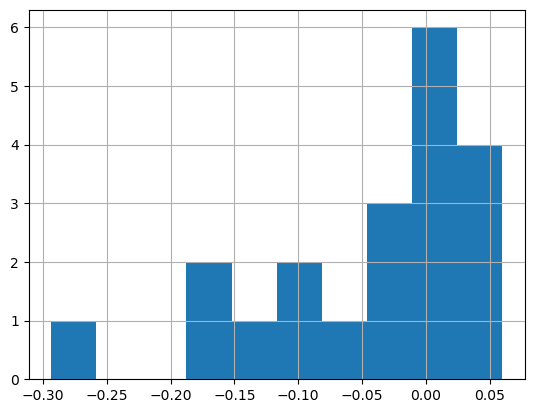

In [15]:
ffdp_lyrics['sentiment_score'].hist();

In [16]:
ffdp_lyrics['sentiment_score'].describe()

count    20.000000
mean     -0.048145
std       0.089823
min      -0.293500
25%      -0.100100
50%      -0.010450
75%       0.004350
max       0.059700
Name: sentiment_score, dtype: float64

In [17]:
ffdp_lyrics['sentiment_score'].sum()

-0.9629

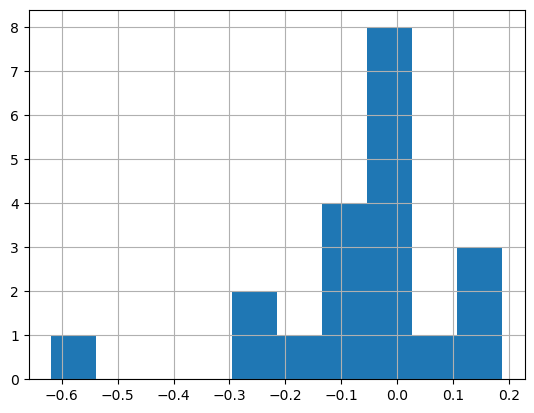

In [18]:
rezz_lyrics['sentiment_score'].hist();

In [19]:
rezz_lyrics['sentiment_score'].sum()

-1.0983999999999998

In [20]:
rezz_lyrics['sentiment_score'].describe()

count    20.000000
mean     -0.054920
std       0.173237
min      -0.619000
25%      -0.074925
50%       0.000000
75%       0.000000
max       0.187500
Name: sentiment_score, dtype: float64

In [21]:
ffdp_lyrics['sentiment_score'].mean()

-0.04814499999999999

In [22]:
rezz_lyrics['sentiment_score'].mean()

-0.05492000000000001

#### A:

FFDP has a slightly higher average sentiment.  And after looking at Rezz's sentiment histogram, we clearly see a good proportion of her songs are at the 0 mark.   In general, songs by Rezz have very little words and according to my previous homework, the Rezz (edm producer) lyrics corpus has half the amount of words in comparison to FFDP (metal band).  This lack of word variety within the Rezz corpus is what makes Rezz lyrics have a lower sentiment score.  Especially when a good amount of her songs containing a majority of negative sentiment words such as shown in an answer for Q2.

STUDENT QUESTION!!!
Would a deeper dive into the actual ratios of positive to negative counts be useful?  If not, what would you do at this point to get better clarification?



------
#### Q2
For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.


In [23]:
ffdp_lyrics.loc[ffdp_lyrics['sentiment_score'].idxmax(),:]

Artist                                                          FFDP
Title                                                   Never_Enough
Lyrics                I'm so fed up with everyone around me No on...
sentiment_score                                               0.0597
Name: 12, dtype: object

In [24]:
ffdp_lyrics.loc[ffdp_lyrics['sentiment_score'].idxmin(),:]

Artist                                                          FFDP
Title                                                   Burn_It_Down
Lyrics                You think you know me? You don't know shit ...
sentiment_score                                              -0.2935
Name: 19, dtype: object

--------
#### Q3
For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.


In [25]:
rezz_lyrics.loc[rezz_lyrics['sentiment_score'].idxmax(),:]

Artist                                                  OfficialRezz
Title                                                          Relax
Lyrics                Just take a nice breath in. Exhale the brea...
sentiment_score                                               0.1875
Name: 2, dtype: object

In [26]:
rezz_lyrics.loc[rezz_lyrics['sentiment_score'].idxmin(),:]

Artist                                                  OfficialRezz
Title                                                   Life_&_Death
Lyrics                Life and Death Death Death  Life Death Life...
sentiment_score                                               -0.619
Name: 3, dtype: object

------
#### Q4
Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.



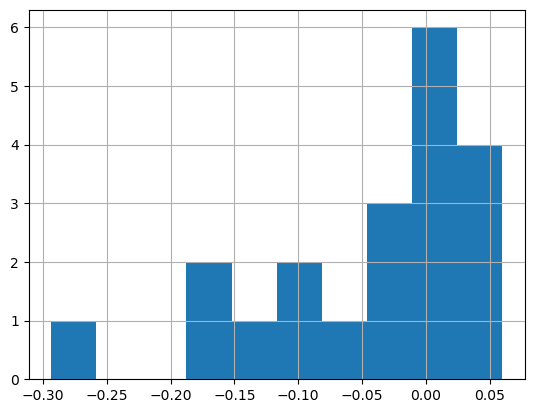

In [27]:
ffdp_lyrics['sentiment_score'].hist();

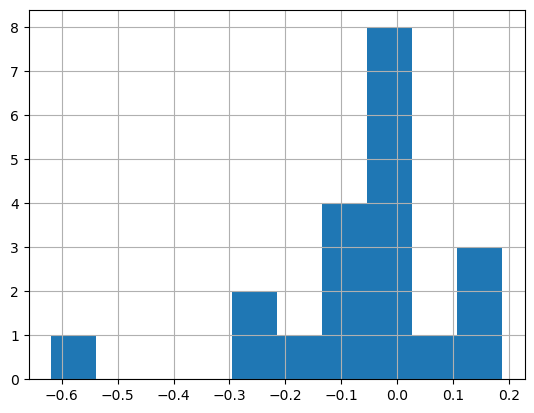

In [28]:
rezz_lyrics['sentiment_score'].hist();

# Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [29]:
neg = [':angry_face:',
        ':backhand_index_pointing_up:',
        ':black_heart:',
        ':broken_heart:',
        ':dissapointed_relieved:',
        ':exploding_head:',
        ':expressionless_face:',
        ':face_exhaling:',
        ':grimacing_face:',
        ':middle_finger:',
        ':pensive_face:',
        ':sob:',
        ':worried_face:']

pos = [':beating_heart:',
       ':beaming_face_with_smiling_eyes:',
       ':blue_heart:',
       ':clapping_hands:',
       ':face_blowing_a_kiss:',
       ':face_with_tears_of_joy:',
       ':fire:',
       ':fireworks:',
       ':folded_hands:',
       ':green_heart:',
       ':growing_heart:',
       ':heart_hands:',
       ':heart_suit:',
       ':kissing_face:',
       ':light_bulb:',
       ':love-you_gesture:',
       ':no_entry:',
       ':purple_heart:',
       ':red_heart:',
       ':revolving_hearts:',
       ':smiling_face_with_sunglasses:',
       ':sparkling_heart:',
       ':sun:',
       ':two_hearts:',
       ':white_heart:',
       ':winking_face:',
       ':yellow_heart:']

sentiments = [neg, pos]

emoji_sentiment_dict = {}
for num, sentiment_type in enumerate(sentiments):
    for emoji_short_hand in sentiment_type:

        if num == 0:
            emoji_sentiment_dict[emoji_short_hand] = -1
        else:
            emoji_sentiment_dict[emoji_short_hand] = 1

## Q1
What is the average sentiment of your two artists?



In [30]:
def emoji_sentiment_scorer(text):
    '''Returns 0 if there is no Emojis in text'''
    sentiment_score = 0
    emoji_count = emoji.emoji_count(text)

    if emoji_count > 0:
        emoji_series = pd.DataFrame(emoji.emoji_list(text))['emoji']

        emoji_text_list = []
        for emoji_graphic in emoji_series:
            emoji_short_hand = emoji.demojize(emoji_graphic)
            emoji_text_list.append(emoji_short_hand)

        for emoji_short_hand in emoji_text_list:
            try:
                sentiment_score += emoji_sentiment_dict[emoji_short_hand]
            except:
                '''Some emojis are able to be both + or - dependent on context
                 & thus are given a 0. I.e. "pleading face".'''
                pass

        sentiment_score = sentiment_score / len(emoji_text_list)
        sentiment_score = round(sentiment_score, 4)
    return sentiment_score


In [31]:
# remove any row with NaN values
ffdp_twitter = ffdp_twitter.dropna().reset_index(drop=True)

rezz_twitter = rezz_twitter.dropna().reset_index(drop=True)

In [32]:
ffdp_twitter['Sentiment'] = ffdp_twitter['Description'].apply(emoji_sentiment_scorer)
ffdp_sentiment = round(ffdp_twitter['Sentiment'].mean(),5)
print(f"FFDP's average sentiment is {ffdp_sentiment}")

FFDP's average sentiment is 0.03897


In [33]:
rezz_twitter['Sentiment'] = rezz_twitter['Description'].apply(emoji_sentiment_scorer)
rezz_sentiment = round(rezz_twitter['Sentiment'].mean(),5)
print(f"FFDP's average sentiment is {rezz_sentiment}")

FFDP's average sentiment is 0.0407


## Q2
Which positive emoji is the most popular for each artist? Which negative emoji?

In [36]:

def top_emojis(artist_twitter_df):
  '''
    Returns top 10 positive emojis.  
    If positive=False, return top 10 negative emojis.
  '''
  emojis_list = []

  for idx, row in artist_twitter_df.iterrows():
      text = row['Description']
      emoji_count = emoji.emoji_count(text)

      if emoji_count > 0:
          emo_series = pd.DataFrame(emoji.emoji_list(text))
          emojis_list.extend(emo_series['emoji'])

  df = pd.DataFrame.from_dict(Counter(emojis_list), orient='index')
  df.reset_index(inplace=True)
  df.rename(columns={'index':'emoji',0:'count'},
              inplace=True)

  df['shorthand'] = df['emoji'].apply(emoji.demojize)

  def shorthand_sentiment_value(shorthand_text):
      try:
        row_emoji = emoji.demojize(shorthand_text)
        sentiment_val = emoji_sentiment_dict[row_emoji]
      except:
        sentiment_val = np.nan

      return sentiment_val

  df['sentiment_val'] = df['shorthand'].apply(shorthand_sentiment_value)
  df = df.dropna()
  df = df.sort_values('count',ascending=False)
  df.reset_index(drop=True, inplace=True)

  return df

def top(top_emoji_df, positive=True, num=10):
  if positive:
     top_emoji_df = top_emoji_df[top_emoji_df['sentiment_val'] == 1].sort_values('count', ascending=False)
     top_emoji_df = top_emoji_df.reset_index(drop=True)
  else:
    top_emoji_df = top_emoji_df[top_emoji_df['sentiment_val'] == -1].sort_values('count', ascending=False)
    top_emoji_df = top_emoji_df.reset_index(drop=True)

  return top_emoji_df.head(num)

### Rezz Top Emojis

In [37]:
rezz_top_emojis = top_emojis(rezz_twitter)
rezz_top_emojis.head(10)

,emoji,count,shorthand,sentiment_val
0,🖤,920,:black_heart:,-1.0
1,❤️,826,:red_heart:,1.0
2,💜,661,:purple_heart:,1.0
3,🔥,540,:fire:,1.0
4,💙,529,:blue_heart:,1.0
5,💕,409,:two_hearts:,1.0
6,🤍,381,:white_heart:,1.0
7,💚,335,:green_heart:,1.0
8,☀️,318,:sun:,1.0
9,💖,299,:sparkling_heart:,1.0


### Rezz Top 10 Positive Emojis

In [38]:
rezz_top_pos = top(rezz_top_emojis, positive=True)
rezz_top_pos_emojis = rezz_top_pos['emoji']
rezz_top_pos

,emoji,count,shorthand,sentiment_val
0,❤️,826,:red_heart:,1.0
1,💜,661,:purple_heart:,1.0
2,🔥,540,:fire:,1.0
3,💙,529,:blue_heart:,1.0
4,💕,409,:two_hearts:,1.0
5,🤍,381,:white_heart:,1.0
6,💚,335,:green_heart:,1.0
7,☀️,318,:sun:,1.0
8,💖,299,:sparkling_heart:,1.0
9,💛,289,:yellow_heart:,1.0


### Rezz Top 10 Negative Emojis

In [39]:
rezz_top_neg = top(rezz_top_emojis, positive=False)
rezz_top_neg_emojis = rezz_top_neg['emoji']
rezz_top_neg

,emoji,count,shorthand,sentiment_val
0,🖤,920,:black_heart:,-1.0
1,💔,75,:broken_heart:,-1.0
2,🤯,34,:exploding_head:,-1.0
3,🖕,20,:middle_finger:,-1.0
4,😔,19,:pensive_face:,-1.0
5,😬,12,:grimacing_face:,-1.0
6,😮‍💨,9,:face_exhaling:,-1.0
7,👆,9,:backhand_index_pointing_up:,-1.0
8,😑,4,:expressionless_face:,-1.0


----------
### FFDP Top Emojis

In [40]:
ffdp_top_emojis = top_emojis(ffdp_twitter)
ffdp_top_emojis.head(10)

,emoji,count,shorthand,sentiment_val
0,🖤,897,:black_heart:,-1.0
1,❤️,718,:red_heart:,1.0
2,💙,476,:blue_heart:,1.0
3,❤,413,:red_heart:,1.0
4,💜,407,:purple_heart:,1.0
5,🔥,292,:fire:,1.0
6,🤍,251,:white_heart:,1.0
7,💚,233,:green_heart:,1.0
8,💕,212,:two_hearts:,1.0
9,😎,195,:smiling_face_with_sunglasses:,1.0


### FFDP Top 10 Positive

In [41]:
ffdp_top_pos = top(ffdp_top_emojis, positive=True)
ffdp_top_pos_emojis = ffdp_top_pos['emoji']
ffdp_top_pos

,emoji,count,shorthand,sentiment_val
0,❤️,718,:red_heart:,1.0
1,💙,476,:blue_heart:,1.0
2,❤,413,:red_heart:,1.0
3,💜,407,:purple_heart:,1.0
4,🔥,292,:fire:,1.0
5,🤍,251,:white_heart:,1.0
6,💚,233,:green_heart:,1.0
7,💕,212,:two_hearts:,1.0
8,😎,195,:smiling_face_with_sunglasses:,1.0
9,💛,170,:yellow_heart:,1.0


### FFDP Top 10 Negative

In [42]:
ffdp_top_neg = top(ffdp_top_emojis, positive=False)
ffdp_top_neg_emojis = ffdp_top_neg['emoji']
ffdp_top_neg

,emoji,count,shorthand,sentiment_val
0,🖤,897,:black_heart:,-1.0
1,💔,53,:broken_heart:,-1.0
2,🖕,51,:middle_finger:,-1.0
3,😬,13,:grimacing_face:,-1.0
4,😔,9,:pensive_face:,-1.0
5,🤯,7,:exploding_head:,-1.0
6,😑,5,:expressionless_face:,-1.0
7,👆,3,:backhand_index_pointing_up:,-1.0
8,😮‍💨,3,:face_exhaling:,-1.0
9,😠,1,:angry_face:,-1.0


##### Top Positive Emojis for both Artist

In [43]:
ffdp_top_pos_emojis.to_frame().merge(rezz_top_pos_emojis,
                                     left_index=True, 
                                     right_index=True,
                                     suffixes=('_ffdp','_rezz'))

,emoji_ffdp,emoji_rezz
0,❤️,❤️
1,💙,💜
2,❤,🔥
3,💜,💙
4,🔥,💕
5,🤍,🤍
6,💚,💚
7,💕,☀️
8,😎,💖
9,💛,💛


Looking at index 8, we can see FFDP fans think they are pretty cool while Rezz fans love the sun.  Other than those two differences, it appears both fan bases love their various hearts.

##### Top Negative Emojis for both Artist

In [44]:
ffdp_top_neg_emojis.to_frame().merge(rezz_top_neg_emojis,
                                     left_index=True, 
                                     right_index=True,
                                     suffixes=('_ffdp','_rezz'))

,emoji_ffdp,emoji_rezz
0,🖤,🖤
1,💔,💔
2,🖕,🤯
3,😬,🖕
4,😔,😔
5,🤯,😬
6,😑,😮‍💨
7,👆,👆
8,😮‍💨,😑


Interesting to see the top emojis for both artist are the same in both the positive and negative light. Then again the amount of negative emojis in my lexicon is only 13 with 26 positive emojis.



# References
---------
Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews." <br>
&nbsp;&nbsp;&nbsp;Proceedings of the ACM SIGKDD International Conference on Knowledge <br>
&nbsp;&nbsp;&nbsp;Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle, <br>
&nbsp;&nbsp;&nbsp;Washington, USA, 